# Exploring topics

**This is the final stage of our work with pure Python: we're searching differences in the use of words related to several topics** 

In [4]:
import sys, os, csv, requests, re, bs4, datetime, time, threading, wget, pdfminer, geopy #geopandas, 
import pandas as pd
import matplotlib.pyplot as plt
from pdfminer.high_level import extract_text
from geopy.geocoders import Nominatim
import numpy as np
from requests import get
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer 
import json
from nltk.corpus import stopwords
path='C:/Users/etien/Python/Ireland'
os.chdir(path)
os.getcwd()
PATH_PLAIN='Reports/Plain text/'
LIST_PLAIN=os.listdir('Reports/Plain text')[:-2]

**Getting the general table of Inspection reports**

In [6]:
general_inspectionReports = pd.read_csv('General_inspectionReports.csv')
def merge_columns(row):
    row.iloc[0] = row.iloc[2] + '_' + row.iloc[1]
    return row
general_inspectionReports = general_inspectionReports.apply(merge_columns, axis='columns')
general_inspectionReports.columns = ['Report Id', 'Date', 'School Roll No.', 'County', 'School Name',
       'School Level', 'Inspection Type', 'Subject', 'URL']
general_inspectionReports = general_inspectionReports.set_index('Report Id')
general_inspectionReports = general_inspectionReports.sort_index()
general_inspectionReports

,Date,School Roll No.,County,School Name,School Level,Inspection Type,Subject,URL
Report Id,,,,,,,,
001125B_24_11_2011,24_11_2011,001125B,Leitrim,St Joseph’s National School Leitrim Village ...,Primary,Whole School Evaluation,NaN,report1_01125B.pdf
00467B_15_12_2011,15_12_2011,00467B,Cork,Ballinspittle National School Kinsale Cork,Primary,Whole School Evaluation,NaN,report1_00467B.pdf
00512D_09_06_2011,09_06_2011,00512D,Cork,Scoil Bhríde Presentation Primary School Mid...,Primary,Whole School Evaluation,NaN,report1_00512D.pdf
00538V_25_10_2012,25_10_2012,00538V,Kerry,"Convent Primary School Daingean Uí Chúis, Co. ...",Primary,Whole School Evaluation,NaN,report1_EV_00538V.pdf
00606M_25_05_2015,25_05_2015,00606M,Tipperary N.R.,"Monard National School, Monard, Co Tipperary",Primary,Whole School Evaluation,NaN,report1_00606M.pdf
...,...,...,...,...,...,...,...,...
91614B_02_12_2020,02_12_2020,91614B,Kildare,Celbridge Community School Moortown Maynooth R...,Post Primary,Whole School Evaluation,NaN,91614B_WSEMLLPP_14535_20200324.pdf
ST0008_30_06_2011,30_06_2011,ST0008,Dublin,Cara Park Traveller Training Centre Belcamp L...,Post Primary,Whole School Evaluation,NaN,report1_ST0008.pdf
YR0007_09_06_2011,09_06_2011,YR0007,Clare,Kilrush Youthreach Centre Adult Learning Centr...,Post Primary,Whole School Evaluation,NaN,report1_YR0007.pdf


## Word collections for 6 topics
(they were generated in other notebooks)

In [9]:
non_sports_activities_collection=['chess', 'drama', 'choral', 'choral singing', 'music', 'quizzes', 'concerts', 'games', 'field  trips', 'poetry','rhymes', 'song', 'relaxation','creativity', 'self-expression','school  band','playing musical instruments','Irish  cultural  events','Irish club', 'Irish dancing', 'wellbeing committee','reading challenges', 'mathletics', 'mathematics for fun', 'welcome meetings for new parents','cultural outings']
sports_collection=[
 'sports',
 'competitions',
 'match',
 'sport',
 'swimming',
 'football',
 'ball',
 'basketball',
 'rugby',
 'gym',
 'soccer',
 'athletics',
 'gymnastics',
 'tennis',
 'coaches',
 'hockey',
 'handball',
 'player',
 'cycling',
 'aquatics',
 'cricket',
 'equestrian',
 'league',
 'badminton',
 'table tennis',
 'yoga',
 'hurling',
 'aquatics',
 'Gaelic games',
 'Gaelic football',
 'tag-rugby','playground games','PE','PE curriculum']
positive_collection = list({'achieve',
 'commendable',
 'competent',
 'effective',
 'excellent',
 'exceptionally',
 'exemplary',
 'good',
 'high',
 'highly',
 'impact',
 'notable',
 'outstanding',
 'successful',
 'useful',
 'valuable'})
negative_collection = list({'concern',
 'deficiencies',
 'difficulties',
 'difficulty',
 'fair',
 'improve',
 'improvements',
 'ineffective',
 'insufficient',
 'poor',
 'serious',
 'shortcomings',
 'unsatisfactory',
 'weak',
 'weaknesses'})
computer_collection = ['computer',
 'computers',
 'internet',
 'calculators',
 'computing',
 'laptop',
 'software',
 'video',
 'machines',
 'desktop',
 'hardware',
 'electronic',
 'keyboard',
 'calculation',
 'tablet',
 'calculator',
 'digital',
 'screen',
 'computational',
 'computation']
safety_collection = [{'accident',
 'attack',
 'blast',
 'clean',
 'cleaner',
 'cleaners',
 'cleaning',
 'cleanliness',
 'crisis',
 'damage',
 'danger',
 'dangerous',
 'dangers',
 'defence',
 'devastating',
 'emergency',
 'exposure',
 'fear',
 'fire',
 'guard',
 'harm',
 'hazard',
 'hazardous',
 'hazards',
 'health',
 'healthy',
 'hygiene',
 'hygienic',
 'ill',
 'incident',
 'incidents',
 'injury',
 'maintenance',
 'neatness',
 'police',
 'prevention',
 'protect',
 'protection',
 'protective',
 'rehabilitation',
 'remedial',
 'risk',
 'risks',
 'risky',
 'safe',
 'safeguard',
 'safeguarding',
 'safely',
 'safer',
 'safety',
 'sanitary',
 'secure',
 'security',
 'surety',
 'threat',
 'threatening',
 'threats',
 'tidiness',
 'unhealthy',
 'unsafe',
 'urgency',
 'vigilance',
 'vulnerable',
 'warning'}]
collections = [safety_collection,computer_collection,negative_collection,positive_collection,sports_collection,non_sports_activities_collection]
collections_name = ['safety','computer','negative','positive','sports','non_sports_activities']

## Retrieving word counts across the corpus and creating JSON files and a single dataframe

In [11]:
def merge_columns(row):
    row.iloc[0] = row.iloc[0] + '_' + row.iloc[1]
    return row

def data_from_topic(topic, topic_words):
    data_json=[{'topic': topic, 'value_by_school':[]}]
    for fname in LIST_PLAIN:
        f=open(PATH_PLAIN + fname,'r')
        count=0
        for line in f.readlines():
            for word in [word.strip() for word in line.split()]:
                if word in topic_words :
                    count+=1
        data_json[0]['value_by_school'].append({'school':fname[:6],'date': fname[7:17], topic + '_value' : count})
        
    data_df=pd.DataFrame(data_json[0]['value_by_school'])
    data_df = data_df.apply(merge_columns, axis='columns')
    data_df.columns = ['Report Id', 'date', topic + '_value'] #i renamed Report Id and sports_value
    data_df = data_df.set_index('Report Id')
    data_df = data_df.drop('date', axis=1)
    data_df = data_df.sort_index()
    return data_json, data_df

collection_jsons = []
collection_dfs = []

for i in range(6):
    data_json, data_df = data_from_topic(collections_name[i], collections[i])
    collection_jsons.append(data_json)
    collection_dfs.append(data_df)

In [13]:
for i in range(6):
    fname = collections_name[i] + '.json'
    f=open(fname,'w')
    json.dump(collection_jsons[i],f)

In [16]:
for i in range(6):
    general_inspectionReports=general_inspectionReports.join(collection_dfs[i], how='outer')

In [18]:
general_inspectionReports=general_inspectionReports.dropna(subset=['safety_value'])

In [19]:
general_inspectionReports.to_csv('general_inspectionReports_values.csv')

In [22]:
general_inspectionReports

,Date,School Roll No.,County,School Name,School Level,Inspection Type,Subject,URL,safety_value,computer_value,negative_value,positive_value,sports_value,non_sports_activities_value
Report Id,,,,,,,,,,,,,,
00467B_15_12_2011,15_12_2011,00467B,Cork,Ballinspittle National School Kinsale Cork,Primary,Whole School Evaluation,NaN,report1_00467B.pdf,0.0,0.0,3.0,28.0,1.0,5.0
00538V_25_10_2012,25_10_2012,00538V,Kerry,"Convent Primary School Daingean Uí Chúis, Co. ...",Primary,Whole School Evaluation,NaN,report1_EV_00538V.pdf,0.0,0.0,1.0,17.0,2.0,3.0
00606M_25_05_2015,25_05_2015,00606M,Tipperary N.R.,"Monard National School, Monard, Co Tipperary",Primary,Whole School Evaluation,NaN,report1_00606M.pdf,0.0,0.0,3.0,25.0,1.0,1.0
00729F_23_06_2014,23_06_2014,00729F,Dublin,"Loreto Primary School, Rathfarnham, Dublin 14",Primary,Whole School Evaluation,NaN,report1_00729F.pdf,0.0,0.0,3.0,30.0,1.0,0.0
00752A_15_10_2012,15_10_2012,00752A,Dublin,"Central Model Senior National School, Marlboro...",Primary,Whole School Evaluation,NaN,report1_00752A.pdf,0.0,0.0,1.0,35.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91516B_21_09_2018,21_09_2018,91516B,Cork,"Skibbereen Community School, Main St, Skibbere...",Post Primary,Whole School Evaluation,NaN,91516B_WSEMLLPP_7225_20180516.pdf,0.0,0.0,9.0,86.0,0.0,0.0
91517D_24_06_2014,24_06_2014,91517D,Meath,"Athboy Community School, Athboy, Co. Meath",Post Primary,Whole School Evaluation,NaN,report7_91517D.pdf,0.0,0.0,9.0,50.0,1.0,0.0
91530S_07_11_2014,07_11_2014,91530S,Kildare,"Kildare Town Community School, Kildare, Co. Ki...",Post Primary,Whole School Evaluation,NaN,report3_91539S.pdf,0.0,1.0,2.0,29.0,0.0,0.0


## Exploring the counties difference by word count for each topics
We dropped the safety topic because of problem occured during the last-minute rush

In [23]:
counties_df_dict = {}
for county in general_inspectionReports.County.unique():
  df_county = general_inspectionReports[general_inspectionReports["County"] == f"{county}"]
  counties_df_dict[county] = df_county

print(list(counties_df_dict.keys()))
print([v.shape for v in counties_df_dict.values()])

['Cork', 'Kerry', 'Tipperary N.R.', 'Dublin', 'Kildare', 'Longford', 'Westmeath', 'Wicklow', 'Galway', 'Roscommon', nan, 'Kilkenny', 'Cavan', 'Meath', 'Donegal', 'Mayo', 'Wexford', 'Carlow', 'Tipperary S.R.', 'Louth', 'Offaly', 'Clare', 'Limerick', 'Sligo', 'Waterford', 'Tipperary', 'Laois', 'Leitrim', 'Monaghan']
[(234, 14), (85, 14), (29, 14), (357, 14), (79, 14), (27, 14), (45, 14), (47, 14), (127, 14), (41, 14), (0, 14), (59, 14), (42, 14), (74, 14), (103, 14), (77, 14), (68, 14), (29, 14), (33, 14), (63, 14), (45, 14), (71, 14), (87, 14), (36, 14), (55, 14), (13, 14), (27, 14), (26, 14), (34, 14)]


In [90]:
nat_mean = general_inspectionReports.describe().loc['mean',:] ### national means
nat_mean

safety_value                    0.000000
computer_value                  0.849457
negative_value                  3.160415
positive_value                 30.233959
sports_value                    0.525173
non_sports_activities_value     0.968411
Name: mean, dtype: float64

## How is Cork county doing compared with the rest of Ireland ?
we express the Cork county's mean word count for each topic as % national mean

In [89]:
(counties_df_dict['Cork'].describe().loc['mean',:]/nat_mean*100).dropna()

computer_value                 115.206822
negative_value                  73.424316
positive_value                  90.250586
sports_value                   128.569822
non_sports_activities_value    101.496816
Name: mean, dtype: float64

## Disparities among counties with respect to non-sport activities

In [57]:
for county in general_inspectionReports.County.unique():
    print(county)
    print(counties_df_dict[county].describe().loc['mean','non_sports_activities_value']/nat_mean.loc['non_sports_activities_value']*100)
    print()

Cork
101.49681556409385

Kerry
77.7501948791749

Tipperary N.R.
96.14046187915216

Dublin
85.03927564909756

Kildare
87.57661389179215

Longford
80.31487144636992

Westmeath
87.1990032846302

Wicklow
59.320710521178995

Galway
136.59852151508585

Roscommon
148.59650431366697

nan
nan

Kilkenny
84.0097444669051

Cavan
105.72059608756857

Meath
100.47111331515002

Donegal
104.26452104549548

Mayo
111.3083654368058

Wexford
78.96504167416202

Carlow
35.607578473760064

Tipperary S.R.
56.32471504031137

Louth
88.51026649191786

Offaly
80.31487144636992

Clare
266.1541112116122

Limerick
106.8227354212802

Sligo
100.3935893079624

Waterford
86.36456306181076

Tipperary
55.60260330902532

Laois
76.49035375844754

Leitrim
150.921351838783

Monaghan
60.7423397493554



**No time to make a better bar-chart ! this is the counties' average non-sports-activities word count expressed as % of national average.** 

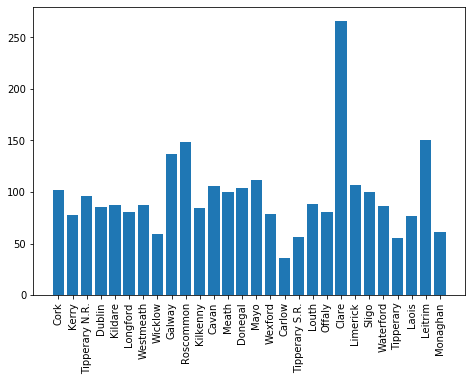

In [88]:
counties = [county for county in general_inspectionReports.County.unique()]
del counties[10]
scores = [counties_df_dict[county].describe().loc['mean','non_sports_activities_value']
          /nat_mean.loc['non_sports_activities_value']*100 for county in counties]
x=[i for i in range(28)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xticks(x, counties, rotation='vertical')
ax.bar(counties,scores)
plt.savefig("plot.png")

In [86]:
plt.savefig("plot.svg")

<Figure size 432x288 with 0 Axes>

In [87]:
plt.savefig("plot.png")

<Figure size 432x288 with 0 Axes>

**Same for the 5 topics**

In [41]:
score = {}
for county in general_inspectionReports.County.unique():
    score[county]={}
    print(county)
    print((counties_df_dict[county].describe().loc['mean',:]/nat_mean*100).dropna())
    print()
    s=(counties_df_dict[county].describe().loc['mean',:]/nat_mean*100).dropna()
    for index, value in s.iteritems():
        score[county][index]=value
score

Cork
computer_value                 115.206822
negative_value                  73.424316
positive_value                  90.250586
sports_value                   128.569822
non_sports_activities_value    101.496816
Name: mean, dtype: float64

Kerry
computer_value                 87.252965
negative_value                 53.232033
positive_value                 78.174659
sports_value                   62.724458
non_sports_activities_value    77.750195
Name: mean, dtype: float64

Tipperary N.R.
computer_value                 73.068986
negative_value                 74.193670
positive_value                 80.521469
sports_value                   98.489759
non_sports_activities_value    96.140462
Name: mean, dtype: float64

Dublin
computer_value                 105.191594
negative_value                 127.717881
positive_value                 120.062743
sports_value                    95.473453
non_sports_activities_value     85.039276
Name: mean, dtype: float64

Kildare
computer_value   

{'Cork': {'computer_value': 115.20682171466599,
  'negative_value': 73.42431632608113,
  'positive_value': 90.25058611208088,
  'sports_value': 128.56982199087463,
  'non_sports_activities_value': 101.49681556409385},
 'Kerry': {'computer_value': 87.25296510236868,
  'negative_value': 53.232032778752604,
  'positive_value': 78.17465942200174,
  'sports_value': 62.72445820433437,
  'non_sports_activities_value': 77.7501948791749},
 'Tipperary N.R.': {'computer_value': 73.06898555370776,
  'negative_value': 74.19366999305281,
  'positive_value': 80.52146911165829,
  'sports_value': 98.48975887995852,
  'non_sports_activities_value': 96.14046187915216},
 'Dublin': {'computer_value': 105.19159435999852,
  'negative_value': 127.71788084279471,
  'positive_value': 120.06274282985146,
  'sports_value': 95.4734525389103,
  'non_sports_activities_value': 85.03927564909756},
 'Kildare': {'computer_value': 123.6828749843703,
  'negative_value': 116.1520410725194,
  'positive_value': 111.702712878

In [46]:
score

{'Cork': {'computer_value': 115.20682171466599,
  'negative_value': 73.42431632608113,
  'positive_value': 90.25058611208088,
  'sports_value': 128.56982199087463,
  'non_sports_activities_value': 101.49681556409385},
 'Kerry': {'computer_value': 87.25296510236868,
  'negative_value': 53.232032778752604,
  'positive_value': 78.17465942200174,
  'sports_value': 62.72445820433437,
  'non_sports_activities_value': 77.7501948791749},
 'Tipperary N.R.': {'computer_value': 73.06898555370776,
  'negative_value': 74.19366999305281,
  'positive_value': 80.52146911165829,
  'sports_value': 98.48975887995852,
  'non_sports_activities_value': 96.14046187915216},
 'Dublin': {'computer_value': 105.19159435999852,
  'negative_value': 127.71788084279471,
  'positive_value': 120.06274282985146,
  'sports_value': 95.4734525389103,
  'non_sports_activities_value': 85.03927564909756},
 'Kildare': {'computer_value': 123.6828749843703,
  'negative_value': 116.1520410725194,
  'positive_value': 111.702712878

In [47]:
f=open('scores.json','w')
json.dump([score],f)

**This is, on a national base, the count of each word of each topic-related word collections**

In [49]:
topic_related_word_counts={}
for i in range(1,6):
    topic_related_word_counts[collections_name[i]]={}
    for fname in LIST_PLAIN:
        f=open(PATH_PLAIN + fname,'r')
        for line in f.readlines():
            for word in [word.strip() for word in line.split()]:
                if word in collections[i]:
                    topic_related_word_counts[collections_name[i]][word]=topic_related_word_counts[collections_name[i]].get(word,0)+1
topic_related_word_counts

{'computer': {'computation': 40,
  'digital': 696,
  'computers': 111,
  'software': 69,
  'calculators': 12,
  'computational': 83,
  'computer': 129,
  'laptop': 15,
  'hardware': 20,
  'internet': 60,
  'keyboard': 3,
  'electronic': 214,
  'tablet': 89,
  'calculation': 10,
  'screen': 10,
  'calculator': 1,
  'video': 108,
  'computing': 5,
  'desktop': 4,
  'machines': 3},
 'negative': {'improve': 2394,
  'difficulties': 360,
  'improvements': 814,
  'insufficient': 144,
  'concern': 210,
  'serious': 277,
  'poor': 195,
  'difficulty': 151,
  'fair': 374,
  'weaknesses': 315,
  'unsatisfactory': 42,
  'deficiencies': 624,
  'shortcomings': 413,
  'weak': 41,
  'ineffective': 8},
 'positive': {'successful': 1066,
  'high': 9809,
  'good': 26543,
  'effective': 8298,
  'commendable': 1947,
  'competent': 257,
  'highly': 3986,
  'impact': 1928,
  'excellent': 1542,
  'valuable': 1424,
  'notable': 183,
  'exemplary': 970,
  'useful': 556,
  'achieve': 1251,
  'exceptionally': 597,

In [51]:
f=open('wordcloud.json','w')
json.dump([topic_related_word_counts],f)